 # ADDA for ST

 Creating something like CellDART but it actually follows Adda in PyTorch as a first step

In [1]:
import math
import os
import datetime
from copy import deepcopy
from itertools import count
import warnings

from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import h5py
import pickle
import numpy as np


import torch
from torch.nn import functional as F
from torch import nn

from src.da_models.adda import ADDAST
from src.da_models.datasets import SpotDataset
from src.da_models.utils import set_requires_grad
from src.da_models.utils import initialize_weights
from src.utils.dupstdout import DupStdout
from src.utils.data_loading import load_spatial, load_sc


# datetime object containing current date and time
script_start_time = datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%S")


/tmp/ipykernel_3998065/3260998234.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    warnings.warn("Using CPU", stacklevel=2)


In [3]:
TRAIN_USING_ALL_ST_SAMPLES = False

SAMPLE_ID_N = "151673"

ST_SPLIT = False

BATCH_SIZE = 1024
NUM_WORKERS = 4
INITIAL_TRAIN_EPOCHS = 100


MIN_EPOCHS = 0.4 * INITIAL_TRAIN_EPOCHS
EARLY_STOP_CRIT = INITIAL_TRAIN_EPOCHS

PROCESSED_DATA_DIR = "data/preprocessed_markers_standard"

MODEL_NAME = "ADDA"
MODEL_VERSION = "Standard1"

adda_kwargs = {
    "emb_dim": 64,
    "bn_momentum": 0.01,
}


In [4]:
## Adversarial Hyperparameters

EPOCHS = 200
MIN_EPOCHS_ADV = 0.4 * EPOCHS
EARLY_STOP_CRIT_ADV = EPOCHS
ENC_LR = 0.0002
ADAM_BETA_1 = 0.5
ALPHA = 2
DIS_LOOP_FACTOR = 5


In [5]:
model_folder = os.path.join("model", MODEL_NAME, script_start_time)

model_folder = os.path.join("model", MODEL_NAME, MODEL_VERSION)

if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)

# if not os.path.isdir(results_folder):
#     os.makedirs(results_folder)


In [6]:
# # sc.logging.print_versions()
# sc.set_figure_params(facecolor="white", figsize=(8, 8))
# sc.settings.verbosity = 3


 # Data load

In [7]:
# Load spatial data
mat_sp_d, mat_sp_train_s, st_sample_id_l = load_spatial(
    TRAIN_USING_ALL_ST_SAMPLES, PROCESSED_DATA_DIR, ST_SPLIT
)

# Load sc data
sc_mix_d, lab_mix_d, sc_sub_dict, sc_sub_dict2 = load_sc(PROCESSED_DATA_DIR)


 # Training: Adversarial domain adaptation for cell fraction estimation

 ## Prepare dataloaders

In [8]:
### source dataloaders
source_train_set = SpotDataset(sc_mix_d["train"], lab_mix_d["train"])
source_val_set = SpotDataset(sc_mix_d["val"], lab_mix_d["val"])
source_test_set = SpotDataset(sc_mix_d["test"], lab_mix_d["test"])

dataloader_source_train = torch.utils.data.DataLoader(
    source_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)
dataloader_source_val = torch.utils.data.DataLoader(
    source_val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)
dataloader_source_test = torch.utils.data.DataLoader(
    source_test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)

### target dataloaders
target_test_set_d = {}
for sample_id in st_sample_id_l:
    target_test_set_d[sample_id] = SpotDataset(mat_sp_d["test"][sample_id])

dataloader_target_test_d = {}
for sample_id in st_sample_id_l:
    dataloader_target_test_d[sample_id] = torch.utils.data.DataLoader(
        target_test_set_d[sample_id],
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=False,
    )

if TRAIN_USING_ALL_ST_SAMPLES:
    target_train_set = SpotDataset(mat_sp_train_s)
    dataloader_target_train = torch.utils.data.DataLoader(
        target_train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=False,
    )
    target_train_set_dis = SpotDataset(deepcopy(mat_sp_train_s))
    dataloader_target_train_dis = torch.utils.data.DataLoader(
        target_train_set_dis,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=False,
    )
else:
    target_train_set_d = {}
    dataloader_target_train_d = {}

    target_train_set_dis_d = {}
    dataloader_target_train_dis_d = {}
    for sample_id in st_sample_id_l:
        target_train_set_d[sample_id] = SpotDataset(
            deepcopy(mat_sp_d["train"][sample_id])
        )
        dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )

        target_train_set_dis_d[sample_id] = SpotDataset(
            deepcopy(mat_sp_d["train"][sample_id])
        )
        dataloader_target_train_dis_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_dis_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )


 ## Define Model

In [9]:
model = ADDAST(
    inp_dim=sc_mix_d["train"].shape[1],
    ncls_source=lab_mix_d["train"].shape[1],
    is_adda=True,
    **adda_kwargs
)
model.apply(initialize_weights)
model.to(device)


ADDAST(
  (source_encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=367, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
      (9): ELU(alpha=1.0)
    )
  )
  (clf): AddaPredictor(
    (head): Sequential(
      (0): Linear(in_features=64, out_features=33, bias=True)
    )
  )
)

 ## Pretrain

In [10]:
pretrain_folder = os.path.join(model_folder, "pretrain")

if not os.path.isdir(pretrain_folder):
    os.makedirs(pretrain_folder)


In [11]:
pre_optimizer = torch.optim.Adam(
    model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-07
)

pre_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    pre_optimizer,
    max_lr=0.002,
    steps_per_epoch=len(dataloader_source_train),
    epochs=INITIAL_TRAIN_EPOCHS,
)

criterion_clf = nn.KLDivLoss(reduction="batchmean")


In [12]:
def model_loss(x, y_true, model):
    x = x.to(torch.float32).to(device)
    y_true = y_true.to(torch.float32).to(device)

    y_pred = model(x)

    loss = criterion_clf(y_pred, y_true)

    return loss


def compute_acc(dataloader, model):
    loss_running = []
    mean_weights = []
    model.eval()
    with torch.no_grad():
        for _, batch in enumerate(dataloader):

            loss = model_loss(*batch, model)

            loss_running.append(loss.item())

            # we will weight average by batch size later
            mean_weights.append(len(batch))

    return np.average(loss_running, weights=mean_weights)


In [13]:
model.pretraining()


In [14]:
# Initialize lists to store loss and accuracy values
loss_history = []
loss_history_val = []

loss_history_running = []

# Early Stopping
best_loss_val = np.inf
early_stop_count = 0

with DupStdout().dup_to_file(os.path.join(pretrain_folder, "log.txt"), "w") as f_log:
    # Train
    print("Start pretrain...")
    outer = tqdm(total=INITIAL_TRAIN_EPOCHS, desc="Epochs", position=0)
    inner = tqdm(total=len(dataloader_source_train), desc=f"Batch", position=1)

    checkpoint = {
        "epoch": -1,
        "model": model,
        "optimizer": pre_optimizer,
        "scheduler": pre_scheduler,
        # 'scaler': scaler
    }
    for epoch in range(INITIAL_TRAIN_EPOCHS):
        checkpoint["epoch"] = epoch

        # Train mode
        model.train()
        loss_running = []
        mean_weights = []

        inner.refresh()  # force print final state
        inner.reset()  # reuse bar
        for _, batch in enumerate(dataloader_source_train):
            # lr_history_running.append(scheduler.get_last_lr())

            pre_optimizer.zero_grad()
            loss = model_loss(*batch, model)
            loss_running.append(loss.item())
            mean_weights.append(
                len(batch)
            )  # we will weight average by batch size later

            # scaler.scale(loss).backward()
            # scaler.step(optimizer)
            # scaler.update()

            loss.backward()
            pre_optimizer.step()
            pre_scheduler.step()

            inner.update(1)

        loss_history.append(np.average(loss_running, weights=mean_weights))
        loss_history_running.append(loss_running)

        # Evaluate mode
        model.eval()
        with torch.no_grad():
            curr_loss_val = compute_acc(dataloader_source_val, model)
            loss_history_val.append(curr_loss_val)

        # Print the results
        outer.update(1)
        print(
            "epoch:",
            epoch,
            "train loss:",
            round(loss_history[-1], 6),
            "validation loss:",
            round(loss_history_val[-1], 6),
            # "next_lr:", scheduler.get_last_lr(),
            end=" ",
        )
        # Save the best weights
        if curr_loss_val < best_loss_val:
            best_loss_val = curr_loss_val
            torch.save(checkpoint, os.path.join(pretrain_folder, f"best_model.pth"))
            early_stop_count = 0

            print("<-- new best val loss")
        else:
            print("")

        # Save checkpoint every 10
        if epoch % 10 == 0 or epoch >= INITIAL_TRAIN_EPOCHS - 1:
            torch.save(checkpoint, os.path.join(pretrain_folder, f"checkpt{epoch}.pth"))

        # check to see if validation loss has plateau'd
        if early_stop_count >= EARLY_STOP_CRIT and epoch >= MIN_EPOCHS - 1:
            print(
                f"Validation loss plateaued after {early_stop_count} at epoch {epoch}"
            )
            torch.save(
                checkpoint, os.path.join(pretrain_folder, f"earlystop{epoch}.pth")
            )
            break

        early_stop_count += 1

    # Save final model
    best_checkpoint = torch.load(os.path.join(pretrain_folder, f"best_model.pth"))
    torch.save(best_checkpoint, os.path.join(pretrain_folder, f"final_model.pth"))


Start pretrain...


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 train loss: 2.606392 validation loss: 1.814886 <-- new best val loss
epoch: 1 train loss: 2.014261 validation loss: 1.447061 <-- new best val loss
epoch: 2 train loss: 1.710186 validation loss: 1.283945 <-- new best val loss
epoch: 3 train loss: 1.515462 validation loss: 1.162778 <-- new best val loss
epoch: 4 train loss: 1.373006 validation loss: 1.07429 <-- new best val loss
epoch: 5 train loss: 1.251432 validation loss: 1.015311 <-- new best val loss
epoch: 6 train loss: 1.164843 validation loss: 0.961662 <-- new best val loss
epoch: 7 train loss: 1.092277 validation loss: 0.915175 <-- new best val loss
epoch: 8 train loss: 1.028818 validation loss: 0.877841 <-- new best val loss
epoch: 9 train loss: 0.982976 validation loss: 0.844812 <-- new best val loss
epoch: 10 train loss: 0.93964 validation loss: 0.812835 <-- new best val loss
epoch: 11 train loss: 0.903315 validation loss: 0.78755 <-- new best val loss
epoch: 12 train loss: 0.871271 validation loss: 0.762743 <-- new 

 ## Adversarial Adaptation

In [15]:
advtrain_folder = os.path.join(model_folder, "advtrain")

if not os.path.isdir(advtrain_folder):
    os.makedirs(advtrain_folder)


In [16]:
def cycle_iter(iter):
    while True:
        yield from iter


def iter_skip(iter, n=1):
    for i in range(len(iter) * n):
        if (i % n) == n - 1:
            yield next(iter)
        else:
            yield None, None


In [17]:
criterion_dis = nn.BCEWithLogitsLoss()


In [18]:
def discrim_loss_accu(x, domain, model):
    x = x.to(device)

    if domain == "source":
        y_dis = torch.zeros(x.shape[0], device=device, dtype=x.dtype).view(-1, 1)
        emb = model.source_encoder(x)  # .view(x.shape[0], -1)
    elif domain == "target":
        y_dis = torch.ones(x.shape[0], device=device, dtype=x.dtype).view(-1, 1)
        emb = model.target_encoder(x)  # .view(x.shape[0], -1)
    else:
        raise (
            ValueError,
            f"invalid domain {domain} given, must be 'source' or 'target'",
        )

    y_pred = model.dis(emb)

    loss = criterion_dis(y_pred, y_dis)
    accu = torch.mean(
        (torch.round(torch.sigmoid(y_pred)).to(torch.long) == y_dis).to(torch.float32)
    ).cpu()

    return loss, accu


# def discrim_loss_accu(x_source, x_target, model):
#     # x = x.to(device)

#     x_source, x_target = x_source.to(device), x_target.to(device)

#     # if domain == 'source':
#     #     y_dis = torch.zeros(x.shape[0], device=device, dtype=x.dtype).view(-1, 1)
#     #     emb = model.source_encoder(x) #.view(x.shape[0], -1)
#     # elif domain == 'target':
#     #     y_dis = torch.ones(x.shape[0], device=device, dtype=x.dtype).view(-1, 1)
#     #     emb = model.target_encoder(x) #.view(x.shape[0], -1)
#     # else:
#     #     raise(ValueError, f"invalid domain {domain} given, must be 'source' or 'target'")

#     y_dis = torch.cat(
#         [
#             torch.zeros(x_source.shape[0], device=device, dtype=x_source.dtype).view(
#                 -1, 1
#             ),
#             torch.ones(x_target.shape[0], device=device, dtype=x_target.dtype).view(
#                 -1, 1
#             ),
#         ]
#     )
#     x = torch.cat([x_source, x_target])
#     emb = model.source_encoder(x)  # .view(x.shape[0], -1)
#     y_pred = model.dis(emb)

#     loss = criterion_dis(y_pred, y_dis)
#     accu = torch.mean(
#         (torch.round(y_pred).to(torch.long) == y_dis).to(torch.float32)
#     ).cpu()

#     return loss, accu


def compute_acc_dis(dataloader_source, dataloader_target, model):
    loss_history = []
    accu_history = []
    # iters = max(len(dataloader_source), len(dataloader_target))
    model.eval()
    model.dis.eval()
    model.target_encoder.eval()
    model.source_encoder.eval()
    with torch.no_grad():
        loss_running = []
        accu_running = []
        mean_weights = []
        # batch_cycler = zip(cycle_iter(dataloader_source), cycle_iter(dataloader_target))
        for _, (X, _) in enumerate(dataloader_source):
            X = X.to(device)

            y_dis = torch.zeros(X.shape[0], device=device, dtype=X.dtype).view(-1, 1)

            emb = model.source_encoder(X)  # .view(X.shape[0], -1)

            y_pred = model.dis(emb)

            loss_running.append(criterion_dis(y_pred, y_dis).item())
            accu_running.append(
                torch.mean(
                    (
                        torch.round(torch.sigmoid(y_pred.detach(), dim=1)).to(
                            torch.long
                        )
                        == y_dis.detach()
                    ).to(torch.float32)
                ).cpu()
            )
        loss_history.append(np.average(loss_running, weights=mean_weights))
        accu_history.append(np.average(accu_running, weights=mean_weights))

        loss_running = []
        accu_running = []
        mean_weights = []
        for _, (X, _) in enumerate(dataloader_target):
            X = X.to(device)

            y_dis = torch.ones(X.shape[0], device=device, dtype=X.dtype).view(-1, 1)

            emb = model.source_encoder(X)  # .view(X.shape[0], -1)

            y_pred = model.dis(emb)

            loss_running.append(criterion_dis(y_pred, y_dis).item())
            accu_running.append(
                torch.mean(
                    (
                        torch.round(torch.sigmoid(y_pred.detach(), dim=1)).to(
                            torch.long
                        )
                        == y_dis.detach()
                    ).to(torch.float32)
                ).cpu()
            )
        loss_history.append(np.average(loss_running, weights=mean_weights))
        accu_history.append(np.average(accu_running, weights=mean_weights))

    return np.average(loss_history), np.average(accu_history)


def encoder_loss(x_target, model):
    x_target = x_target.to(device)

    # flip label
    y_dis = torch.zeros(x_target.shape[0], device=device, dtype=x_target.dtype).view(
        -1, 1
    )

    emb_target = model.target_encoder(x_target)  # .view(x_target.shape[0], -1)
    y_pred = model.dis(emb_target)
    loss = criterion_dis(y_pred, y_dis)

    return loss


In [19]:
# def train_adversarial(
#     model,
#     save_folder,
#     dataloader_source_train,
#     dataloader_source_val,
#     dataloader_target_train,
# ):
#     model.to(device)
#     model.advtraining()

#     target_optimizer = torch.optim.Adam(
#         model.target_encoder.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-07
#     )
#     dis_optimizer = torch.optim.Adam(
#         model.dis.parameters(), lr=0.00025, betas=(0.9, 0.999), eps=1e-07
#     )

#     iters = max(len(dataloader_source_train), len(dataloader_target_train))

#     dis_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#         dis_optimizer, max_lr=0.0005, steps_per_epoch=iters, epochs=EPOCHS
#     )
#     target_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#         target_optimizer, max_lr=0.0005, steps_per_epoch=iters, epochs=EPOCHS
#     )

#     n_samples_source = len(dataloader_source_train.dataset)
#     n_samples_target = len(dataloader_target_train.dataset)
#     p = n_samples_source / (n_samples_source + n_samples_target)
#     rand_loss = -(p * np.log(0.5)) - (1 - p) * np.log(0.5)

#     # Initialize lists to store loss and accuracy values
#     loss_history = []
#     accu_history = []
#     loss_history_running = []

#     # Early Stopping
#     best_loss_val = np.inf
#     early_stop_count = 0

#     # Train
#     print("Start adversarial training...")
#     print("Discriminator target loss:", rand_loss)
#     outer = tqdm(total=EPOCHS, desc="Epochs", position=0)
#     inner1 = tqdm(total=iters, desc=f"Batch (Discriminator)", position=1)
#     inner2 = tqdm(total=iters, desc=f"Batch (Encoder)", position=2)
#     checkpoint = {
#         "epoch": -1,
#         "model": model,
#         "dis_optimizer": dis_optimizer,
#         "target_optimizer": target_optimizer,
#         "dis_scheduler": dis_scheduler,
#         "target_scheduler": target_scheduler,
#     }
#     for epoch in range(EPOCHS):
#         checkpoint["epoch"] = epoch

#         # Train mode
#         model.train()

#         loss_running = []
#         accu_running = []
#         mean_weights = []

#         inner1.refresh()  # force print final state
#         inner1.reset()  # reuse bar
#         inner2.refresh()  # force print final state
#         inner2.reset()  # reuse bar

#         model.train_discriminator()
#         model.target_encoder.eval()
#         model.source_encoder.eval()
#         model.dis.train()
#         batch_cycler = zip(
#             cycle_iter(dataloader_source_train), cycle_iter(dataloader_target_train)
#         )
#         for _ in range(iters):
#             # lr_history_running.append(scheduler.get_last_lr())
#             dis_optimizer.zero_grad()

#             (x_source, _), (x_target, _) = next(batch_cycler)
#             loss, accu = discrim_loss_accu(x_source, x_target, model)
#             loss_running.append(loss.item())
#             accu_running.append(accu)
#             mean_weights.append(len(x_source) + len(x_target))

#             # scaler.scale(loss).backward()
#             # scaler.step(optimizer)
#             # scaler.update()

#             loss.backward()
#             dis_optimizer.step()
#             dis_scheduler.step()

#             inner1.update(1)

#         loss_history.append(np.average(loss_running, weights=mean_weights))
#         accu_history.append(np.average(accu_running, weights=mean_weights))
#         loss_history_running.append(loss_running)

#         model.train_target_encoder()
#         model.target_encoder.train()
#         model.source_encoder.eval()
#         model.dis.eval()
#         batch_cycler = zip(
#             cycle_iter(dataloader_source_train), cycle_iter(dataloader_target_train)
#         )
#         for _ in range(iters):
#             target_optimizer.zero_grad()

#             _, (x_target, _) = next(batch_cycler)
#             loss = encoder_loss(x_target, model)

#             loss.backward()
#             target_optimizer.step()
#             target_scheduler.step()

#             inner2.update(1)

#         diff_from_rand = math.fabs(loss_history[-1] - rand_loss)

#         # Print the results
#         outer.update(1)
#         print(
#             "epoch:",
#             epoch,
#             "dis loss:",
#             round(loss_history[-1], 6),
#             "dis accu:",
#             round(accu_history[-1], 6),
#             "difference from random loss:",
#             round(diff_from_rand, 6),
#             # "next_lr:", scheduler.get_last_lr(),
#             end=" ",
#         )

#         # Save the best weights
#         if diff_from_rand < best_loss_val:
#             best_loss_val = diff_from_rand
#             torch.save(checkpoint, os.path.join(save_folder, f"best_model.pth"))
#             early_stop_count = 0

#             print("<-- new best difference from random loss")
#         else:
#             print("")

#         # Save checkpoint every 10
#         if epoch % 10 == 0 or epoch >= EPOCHS - 1:
#             torch.save(checkpoint, os.path.join(save_folder, f"checkpt{epoch}.pth"))

#         # check to see if validation loss has plateau'd
#         if early_stop_count >= EARLY_STOP_CRIT_ADV and epoch > MIN_EPOCHS_ADV - 1:
#             print(
#                 f"Discriminator loss plateaued after {early_stop_count} at epoch {epoch}"
#             )
#             torch.save(checkpoint, os.path.join(save_folder, f"earlystop_{epoch}.pth"))
#             break

#         early_stop_count += 1

#     # Save final model
#     torch.save(checkpoint, os.path.join(save_folder, f"final_model.pth"))


In [20]:
def train_adversarial_iters(
    model,
    save_folder,
    dataloader_source_train,
    dataloader_source_val,
    dataloader_target_train,
    dataloader_target_train_dis,
):
    model.to(device)
    model.advtraining()

    target_optimizer = torch.optim.Adam(
        model.target_encoder.parameters(),
        lr=ENC_LR,
        betas=(ADAM_BETA_1, 0.999),
        eps=1e-07,
    )
    dis_optimizer = torch.optim.Adam(
        model.dis.parameters(), lr=ALPHA * ENC_LR, betas=(ADAM_BETA_1, 0.999), eps=1e-07
    )

    # iters = -(max_len_dataloader // -(1 + DIS_LOOP_FACTOR))  # ceiling divide

    dataloader_lengths = [
        len(dataloader_source_train),
        len(dataloader_target_train),
        len(dataloader_target_train_dis) * DIS_LOOP_FACTOR,
    ]
    max_len_dataloader = np.amax(dataloader_lengths)
    longest = np.argmax(dataloader_lengths)

    iters_val = max(len(dataloader_source_val), len(dataloader_target_train))

    # dis_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    #     dis_optimizer, max_lr=0.0005, steps_per_epoch=iters, epochs=EPOCHS
    # )
    # target_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    #     target_optimizer, max_lr=0.0005, steps_per_epoch=iters, epochs=EPOCHS
    # )

    # Initialize lists to store loss and accuracy values
    loss_history = []
    accu_history = []
    loss_history_val = []
    accu_history_val = []
    loss_history_running = []

    loss_history_gen = []
    loss_history_gen_running = []
    mean_weights_gen = []

    # Early Stopping
    best_loss_val = np.inf
    early_stop_count = 0
    with DupStdout().dup_to_file(os.path.join(save_folder, "log.txt"), "w") as f_log:
        # Train
        print("Start adversarial training...")
        outer = tqdm(total=EPOCHS, desc="Epochs", position=0)
        inner1 = tqdm(total=max_len_dataloader, desc=f"Batch", position=1)
        checkpoint = {
            "epoch": -1,
            "model": model,
            "dis_optimizer": dis_optimizer,
            "target_optimizer": target_optimizer,
            # "dis_scheduler": dis_scheduler,
            # "target_scheduler": target_scheduler,
        }
        for epoch in range(EPOCHS):
            checkpoint["epoch"] = epoch

            # Train mode
            model.train()
            model.target_encoder.train()
            model.source_encoder.eval()
            model.dis.train()

            loss_running = []
            accu_running = []
            mean_weights = []

            loss_running_gen = []
            mean_weights_gen = []

            inner1.refresh()  # force print final state
            inner1.reset()  # reuse bar

            s_train_iter = iter(dataloader_source_train)
            t_train_iter = iter(dataloader_target_train)
            t_train_dis_iter = iter(dataloader_target_train_dis)
            for i in range(max_len_dataloader):
                try:
                    x_source, _ = next(s_train_iter)
                except StopIteration:
                    s_train_iter = iter(dataloader_source_train)
                    x_source, _ = next(s_train_iter)
                try:
                    x_target, _ = next(t_train_iter)
                except StopIteration:
                    t_train_iter = iter(dataloader_target_train)
                    x_target, _ = next(t_train_iter)

                train_encoder_step = (i % DIS_LOOP_FACTOR) == DIS_LOOP_FACTOR - 1

                model.train_discriminator()
                # model.target_encoder.train()
                # model.source_encoder.train()
                # model.dis.train()

                set_requires_grad(model.target_encoder, False)
                set_requires_grad(model.source_encoder, False)
                set_requires_grad(model.dis, True)

                # lr_history_running.append(scheduler.get_last_lr())
                dis_optimizer.zero_grad()

                loss, accu = discrim_loss_accu(x_source, "source", model)
                loss_running.append(loss.item())
                accu_running.append(accu)
                mean_weights.append(len(x_source))

                # scaler.scale(loss).backward()
                # scaler.step(optimizer)
                # scaler.update()

                loss.backward()
                dis_optimizer.step()

                dis_optimizer.zero_grad()

                loss, accu = discrim_loss_accu(x_target, "target", model)
                loss_running.append(loss.item())
                accu_running.append(accu)
                mean_weights.append(len(x_target))

                # scaler.scale(loss).backward()
                # scaler.step(optimizer)
                # scaler.update()

                loss.backward()
                dis_optimizer.step()
                # dis_scheduler.step()

                # print(i % DIS_LOOP_FACTOR)
                if train_encoder_step:
                    try:
                        x_target_enc, _ = next(t_train_dis_iter)
                    except StopIteration:
                        t_train_dis_iter = iter(dataloader_target_train_dis)
                        x_target_enc, _ = next(t_train_dis_iter)
                    model.train_target_encoder()
                    # model.target_encoder.train()
                    # model.source_encoder.train()
                    # model.dis.train()

                    set_requires_grad(model.target_encoder, True)
                    set_requires_grad(model.source_encoder, False)
                    set_requires_grad(model.dis, False)

                    target_optimizer.zero_grad()

                    loss = encoder_loss(x_target_enc, model)

                    loss_running_gen.append(loss.item())
                    mean_weights_gen.append(len(x_target_enc))

                    loss.backward()
                    target_optimizer.step()
                # target_scheduler.step()

                inner1.update(1)
            loss_history.append(np.average(loss_running, weights=mean_weights))
            accu_history.append(np.average(accu_running, weights=mean_weights))
            loss_history_running.append(loss_running)
            loss_history_gen.append(
                np.average(loss_running_gen, weights=mean_weights_gen)
            )
            loss_history_gen_running.append(loss_running_gen)

            model.eval()
            model.dis.eval()
            model.target_encoder.eval()
            model.source_encoder.eval()

            set_requires_grad(model, True)
            set_requires_grad(model.target_encoder, True)
            set_requires_grad(model.source_encoder, True)
            set_requires_grad(model.dis, True)

            # del batch_cycler
            # with torch.no_grad():
            #     curr_loss_val, curr_acc_val = compute_acc_dis(
            #         dataloader_source_val, dataloader_target_train, model
            #     )
            #     loss_history_val.append(curr_loss_val)
            #     accu_history_val.append(curr_loss_val)

            # Print the results
            outer.update(1)
            print(
                "epoch:",
                epoch,
                "gen train loss:",
                round(loss_history_gen[-1], 6),
                "dis train loss:",
                round(loss_history[-1], 6),
                "dis train accu:",
                round(accu_history[-1], 6),
                # "dis val loss:",
                # round(loss_history_val[-1], 6),
                # "dis val accu:",
                # round(accu_history_val[-1], 6),
                # "next_lr:", scheduler.get_last_lr(),
                end=" ",
            )

            # # Save the best weights
            # if diff_from_rand < best_loss_val:
            #     best_loss_val = diff_from_rand
            #     torch.save(checkpoint, os.path.join(save_folder, f"best_model.pth"))
            #     early_stop_count = 0

            #     print("<-- new best difference from random loss")
            # else:
            #     print("")

            print("")

            # Save checkpoint every 10
            if epoch % 10 == 0 or epoch >= EPOCHS - 1:
                torch.save(checkpoint, os.path.join(save_folder, f"checkpt{epoch}.pth"))

            # check to see if validation loss has plateau'd
            if early_stop_count >= EARLY_STOP_CRIT_ADV and epoch > MIN_EPOCHS_ADV - 1:
                print(
                    f"Discriminator loss plateaued after {early_stop_count} at epoch {epoch}"
                )
                torch.save(
                    checkpoint, os.path.join(save_folder, f"earlystop_{epoch}.pth")
                )
                break

            early_stop_count += 1

    # Save final model
    torch.save(checkpoint, os.path.join(save_folder, f"final_model.pth"))

    return loss_history_running, loss_history_gen_running


In [21]:
# st_sample_id_l = [SAMPLE_ID_N]


Adversarial training for ST slide 151509: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/25 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.805352 dis train loss: 0.840844 dis train accu: 0.495506 
epoch: 1 gen train loss: 0.836411 dis train loss: 0.820815 dis train accu: 0.4984 
epoch: 2 gen train loss: 0.826295 dis train loss: 0.811582 dis train accu: 0.501355 
epoch: 3 gen train loss: 0.820071 dis train loss: 0.809754 dis train accu: 0.499541 
epoch: 4 gen train loss: 0.828546 dis train loss: 0.808058 dis train accu: 0.498889 
epoch: 5 gen train loss: 0.825082 dis train loss: 0.806874 dis train accu: 0.500132 
epoch: 6 gen train loss: 0.832842 dis train loss: 0.801809 dis train accu: 0.497829 
epoch: 7 gen train loss: 0.830821 dis train loss: 0.799013 dis train accu: 0.500785 
epoch: 8 gen train loss: 0.805602 dis train loss: 0.795474 dis train accu: 0.500744 
epoch: 9 gen train loss: 0.823256 dis train loss: 0.78868 dis train accu: 0.504637 
epoch: 10 gen train loss: 0.824542 dis train loss: 0.786233 dis train accu: 0.501416 
epoch: 11 gen train loss: 0.806731 dis train loss: 0.786843 dis tra

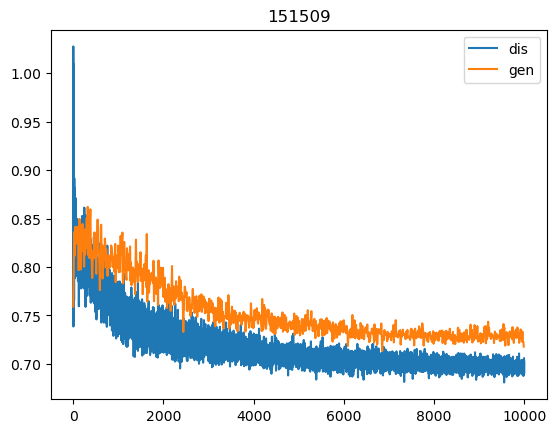

Adversarial training for ST slide 151510: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/25 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.854339 dis train loss: 0.845997 dis train accu: 0.491137 
epoch: 1 gen train loss: 0.839088 dis train loss: 0.828502 dis train accu: 0.496666 
epoch: 2 gen train loss: 0.843289 dis train loss: 0.820138 dis train accu: 0.497287 
epoch: 3 gen train loss: 0.847788 dis train loss: 0.817597 dis train accu: 0.499337 
epoch: 4 gen train loss: 0.84513 dis train loss: 0.811758 dis train accu: 0.499814 
epoch: 5 gen train loss: 0.827509 dis train loss: 0.812372 dis train accu: 0.499669 
epoch: 6 gen train loss: 0.822275 dis train loss: 0.811318 dis train accu: 0.496252 
epoch: 7 gen train loss: 0.81449 dis train loss: 0.802818 dis train accu: 0.502692 
epoch: 8 gen train loss: 0.816982 dis train loss: 0.799794 dis train accu: 0.499027 
epoch: 9 gen train loss: 0.836028 dis train loss: 0.798094 dis train accu: 0.499959 
epoch: 10 gen train loss: 0.8148 dis train loss: 0.79644 dis train accu: 0.498095 
epoch: 11 gen train loss: 0.829046 dis train loss: 0.794897 dis train

In [22]:
if TRAIN_USING_ALL_ST_SAMPLES:
    print(f"Adversarial training for all ST slides")
    save_folder = advtrain_folder

    best_checkpoint = torch.load(os.path.join(pretrain_folder, f"final_model.pth"))
    model = ADDAST(
        sc_mix_d["train"].shape[1],
        ncls_source=lab_mix_d["train"].shape[1],
        is_adda=True,
        **adda_kwargs,
    )

    model.source_encoder.load_state_dict(
        best_checkpoint["model"].source_encoder.state_dict()
    )
    model.clf.load_state_dict(best_checkpoint["model"].clf.state_dict())

    model.init_adv()
    model.dis.apply(initialize_weights)
    model.to(device)

    model.advtraining()

    train_adversarial_iters(
        model,
        save_folder,
        dataloader_source_train,
        dataloader_source_val,
        dataloader_target_train,
        dataloader_target_train_dis,
    )

else:
    for sample_id in st_sample_id_l:
        print(f"Adversarial training for ST slide {sample_id}: ")

        save_folder = os.path.join(advtrain_folder, sample_id)
        if not os.path.isdir(save_folder):
            os.makedirs(save_folder)

        best_checkpoint = torch.load(os.path.join(pretrain_folder, f"final_model.pth"))

        model = ADDAST(
            sc_mix_d["train"].shape[1],
            ncls_source=lab_mix_d["train"].shape[1],
            is_adda=True,
            **adda_kwargs,
        )

        model.apply(initialize_weights)

        # load state dicts
        # this makes it easier, if, say, the discriminator changes
        model.source_encoder.load_state_dict(
            best_checkpoint["model"].source_encoder.state_dict()
        )

        model.clf.load_state_dict(best_checkpoint["model"].clf.state_dict())

        model.init_adv()
        model.dis.apply(initialize_weights)

        model.to(device)

        model.advtraining()

        loss_history_running, loss_history_gen_running = train_adversarial_iters(
            model,
            save_folder,
            dataloader_source_train,
            dataloader_source_val,
            dataloader_target_train_d[sample_id],
            dataloader_target_train_dis_d[sample_id],
        )
        loss_history_gen_running = np.ravel(loss_history_gen_running)
        x = np.arange(
            0,
            len(loss_history_gen_running) * (DIS_LOOP_FACTOR * 2),
            DIS_LOOP_FACTOR * 2,
        )

        plt.plot(np.ravel(loss_history_running), label="dis")
        plt.plot(x, loss_history_gen_running, label="gen")
        plt.legend()
        plt.title(sample_id)
        plt.show()


## Evaluation of latent space

In [ ]:
# from sklearn.decomposition import PCA
# from sklearn import model_selection
# from sklearn.ensemble import RandomForestClassifier


# for sample_id in st_sample_id_l:
#     best_checkpoint = torch.load(
#         os.path.join(advtrain_folder, sample_id, f"final_model.pth")
#     )
#     model = best_checkpoint["model"]
#     model.to(device)

#     model.eval()
#     model.target_inference()

#     with torch.no_grad():
#         source_emb = model.source_encoder(torch.Tensor(sc_mix_train_s).to(device))
#         target_emb = model.target_encoder(
#             torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)
#         )

#         y_dis = torch.cat(
#             [
#                 torch.zeros(source_emb.shape[0], device=device, dtype=torch.long),
#                 torch.ones(target_emb.shape[0], device=device, dtype=torch.long),
#             ]
#         )

#         emb = torch.cat([source_emb, target_emb])

#         emb = emb.detach().cpu().numpy()
#         y_dis = y_dis.detach().cpu().numpy()

#     (emb_train, emb_test, y_dis_train, y_dis_test,) = model_selection.train_test_split(
#         emb,
#         y_dis,
#         test_size=0.2,
#         random_state=225,
#         stratify=y_dis,
#     )

#     pca = PCA(n_components=50)
#     pca.fit(emb_train)

#     emb_train_50 = pca.transform(emb_train)
#     emb_test_50 = pca.transform(emb_test)

#     clf = RandomForestClassifier(random_state=145, n_jobs=-1)
#     clf.fit(emb_train_50, y_dis_train)
#     accu_train = clf.score(emb_train_50, y_dis_train)
#     accu_test = clf.score(emb_test_50, y_dis_test)
#     class_proportions = np.mean(y_dis)

#     print(
#         "Training accuracy: {}, Test accuracy: {}, Class proportions: {}".format(
#             accu_train, accu_test, class_proportions
#         )
#     )


 # 4. Predict cell fraction of spots and visualization

In [ ]:
# pred_sp_d, pred_sp_noda_d = {}, {}
# if TRAIN_USING_ALL_ST_SAMPLES:
#     best_checkpoint = torch.load(os.path.join(advtrain_folder, f"final_model.pth"))
#     model = best_checkpoint["model"]
#     model.to(device)

#     model.eval()
#     model.target_inference()
#     with torch.no_grad():
#         for sample_id in st_sample_id_l:
#             pred_sp_d[sample_id] = (
#                 torch.exp(
#                     model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device))
#                 )
#                 .detach()
#                 .cpu()
#                 .numpy()
#             )

# else:
#     for sample_id in st_sample_id_l:
#         best_checkpoint = torch.load(
#             os.path.join(advtrain_folder, sample_id, f"final_model.pth")
#         )
#         model = best_checkpoint["model"]
#         model.to(device)

#         model.eval()
#         model.target_inference()

#         with torch.no_grad():
#             pred_sp_d[sample_id] = (
#                 torch.exp(
#                     model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device))
#                 )
#                 .detach()
#                 .cpu()
#                 .numpy()
#             )


# best_checkpoint = torch.load(os.path.join(pretrain_folder, f"best_model.pth"))
# model = best_checkpoint["model"]
# model.to(device)

# model.eval()
# model.set_encoder("source")

# with torch.no_grad():
#     for sample_id in st_sample_id_l:
#         pred_sp_noda_d[sample_id] = (
#             torch.exp(model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)))
#             .detach()
#             .cpu()
#             .numpy()
#         )


In [ ]:
# adata_spatialLIBD = sc.read_h5ad(
#     os.path.join(PROCESSED_DATA_DIR, "adata_spatialLIBD.h5ad")
# )

# adata_spatialLIBD_d = {}
# for sample_id in st_sample_id_l:
#     adata_spatialLIBD_d[sample_id] = adata_spatialLIBD[
#         adata_spatialLIBD.obs.sample_id == sample_id
#     ]
#     adata_spatialLIBD_d[sample_id].obsm["spatial"] = (
#         adata_spatialLIBD_d[sample_id].obs[["X", "Y"]].values
#     )


In [ ]:
# num_name_exN_l = []
# for k, v in sc_sub_dict.items():
#     if "Ex" in v:
#         num_name_exN_l.append((k, v, int(v.split("_")[1])))
# num_name_exN_l.sort(key=lambda a: a[2])
# num_name_exN_l


In [ ]:
# Ex_to_L_d = {
#     1: {5, 6},
#     2: {5},
#     3: {4, 5},
#     4: {6},
#     5: {5},
#     6: {4, 5, 6},
#     7: {4, 5, 6},
#     8: {5, 6},
#     9: {5, 6},
#     10: {2, 3, 4},
# }


In [ ]:
# numlist = [t[0] for t in num_name_exN_l]
# Ex_l = [t[2] for t in num_name_exN_l]
# num_to_ex_d = dict(zip(numlist, Ex_l))


In [ ]:
# def plot_cellfraction(visnum, adata, pred_sp, ax=None):
#     """Plot predicted cell fraction for a given visnum"""
#     adata.obs["Pred_label"] = pred_sp[:, visnum]
#     # vmin = 0
#     # vmax = np.amax(pred_sp)

#     sc.pl.spatial(
#         adata,
#         img_key="hires",
#         color="Pred_label",
#         palette="Set1",
#         size=1.5,
#         legend_loc=None,
#         title=f"{sc_sub_dict[visnum]}",
#         spot_size=100,
#         show=False,
#         # vmin=vmin,
#         # vmax=vmax,
#         ax=ax,
#     )


In [ ]:
# def plot_roc(visnum, adata, pred_sp, name, ax=None):
#     """Plot ROC for a given visnum"""

#     def layer_to_layer_number(x):
#         for char in x:
#             if char.isdigit():
#                 if int(char) in Ex_to_L_d[num_to_ex_d[visnum]]:
#                     return 1
#         return 0

#     y_pred = pred_sp[:, visnum]
#     y_true = adata.obs["spatialLIBD"].map(layer_to_layer_number).fillna(0)
#     # print(y_true)
#     # print(y_true.isna().sum())
#     RocCurveDisplay.from_predictions(y_true=y_true, y_pred=y_pred, name=name, ax=ax)


In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout=True)

# sc.pl.spatial(
#     adata_spatialLIBD_d[SAMPLE_ID_N],
#     img_key=None,
#     color="spatialLIBD",
#     palette="Accent_r",
#     size=1.5,
#     title=SAMPLE_ID_N,
#     # legend_loc = 4,
#     spot_size=100,
#     show=False,
#     ax=ax,
# )

# ax.axis("equal")
# ax.set_xlabel("")
# ax.set_ylabel("")

# fig.show()


In [ ]:
# fig, ax = plt.subplots(2, 5, figsize=(20, 8), constrained_layout=True)

# for i, num in enumerate(numlist):
#     plot_cellfraction(
#         num, adata_spatialLIBD_d[SAMPLE_ID_N], pred_sp_d[SAMPLE_ID_N], ax.flat[i]
#     )
#     ax.flat[i].axis("equal")
#     ax.flat[i].set_xlabel("")
#     ax.flat[i].set_ylabel("")

# fig.show()

# fig, ax = plt.subplots(
#     2, 5, figsize=(20, 8), constrained_layout=True, sharex=True, sharey=True
# )

# for i, num in enumerate(numlist):
#     plot_roc(
#         num,
#         adata_spatialLIBD_d[SAMPLE_ID_N],
#         pred_sp_d[SAMPLE_ID_N],
#         "ADDA",
#         ax.flat[i],
#     )
#     plot_roc(
#         num,
#         adata_spatialLIBD_d[SAMPLE_ID_N],
#         pred_sp_noda_d[SAMPLE_ID_N],
#         "NN_wo_da",
#         ax.flat[i],
#     )
#     ax.flat[i].plot([0, 1], [0, 1], transform=ax.flat[i].transAxes, ls="--", color="k")
#     ax.flat[i].set_aspect("equal")
#     ax.flat[i].set_xlim([0, 1])
#     ax.flat[i].set_ylim([0, 1])

#     ax.flat[i].set_title(f"{sc_sub_dict[num]}")

#     if i >= len(numlist) - 5:
#         ax.flat[i].set_xlabel("FPR")
#     else:
#         ax.flat[i].set_xlabel("")
#     if i % 5 == 0:
#         ax.flat[i].set_ylabel("TPR")
#     else:
#         ax.flat[i].set_ylabel("")

# fig.show()


In [ ]:
# if TRAIN_USING_ALL_ST_SAMPLES:
#     best_checkpoint = torch.load(os.path.join(advtrain_folder, f"final_model.pth"))
# else:
#     best_checkpoint = torch.load(
#         os.path.join(advtrain_folder, SAMPLE_ID_N, f"final_model.pth")
#     )

# model = best_checkpoint["model"]
# model.to(device)

# model.eval()
# model.set_encoder("source")

# with torch.no_grad():
#     pred_mix = (
#         torch.exp(model(torch.Tensor(sc_mix_test_s).to(device)))
#         .detach()
#         .cpu()
#         .numpy()
#     )

# cell_type_nums = sc_sub_dict.keys()
# nrows = ceil(len(cell_type_nums) / 5)

# line_kws = {"color": "tab:orange"}
# scatter_kws = {"s": 5}

# props = dict(facecolor="w", alpha=0.5)

# fig, ax = plt.subplots(
#     nrows,
#     5,
#     figsize=(25, 5 * nrows),
#     constrained_layout=True,
#     sharex=False,
#     sharey=True,
# )
# for i, visnum in enumerate(cell_type_nums):
#     sns.regplot(
#         x=pred_mix[:, visnum],
#         y=lab_mix_test[:, visnum],
#         line_kws=line_kws,
#         scatter_kws=scatter_kws,
#         ax=ax.flat[i],
#     ).set_title(sc_sub_dict[visnum])

#     ax.flat[i].set_aspect("equal")
#     ax.flat[i].set_xlabel("Predicted Proportion")

#     if i % 5 == 0:
#         ax.flat[i].set_ylabel("True Proportion")
#     else:
#         ax.flat[i].set_ylabel("")
#     ax.flat[i].set_xlim([0, 1])
#     ax.flat[i].set_ylim([0, 1])

#     textstr = (
#         f"MSE: {mean_squared_error(pred_mix[:,visnum], lab_mix_test[:,visnum]):.5f}"
#     )

#     # place a text box in upper left in axes coords
#     ax.flat[i].text(
#         0.95,
#         0.05,
#         textstr,
#         transform=ax.flat[i].transAxes,
#         verticalalignment="bottom",
#         horizontalalignment="right",
#         bbox=props,
#     )

# for i in range(len(cell_type_nums), nrows * 5):
#     ax.flat[i].axis("off")

# plt.show()
